In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_squared_error
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
import math
import torch
import holidays
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold
from torch import nn
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
import random
import os
from sklearn.cluster import KMeans, DBSCAN, BisectingKMeans, Birch
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_set = pd.read_excel("./drive/MyDrive/dacon/aiml_test_data.xlsx")

In [ ]:
# 중복값 제거
data_set.drop_duplicates(inplace=True)

In [ ]:
data_set.shape

(10000, 8)

In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   port_of_loading             10000 non-null  object        
 1   port_of_discharge           10000 non-null  object        
 2   HSCODE                      10000 non-null  int64         
 3   is_coc                      10000 non-null  bool          
 4   cargo_weight                10000 non-null  float64       
 5   expected_time_of_departure  10000 non-null  datetime64[ns]
 6   teu                         10000 non-null  int64         
 7   paid_amount                 10000 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 556.8+ KB


In [ ]:
selected_for_x = ['HSCODE', 'is_coc', 'cargo_weight', 'year', 'month', 'day', 'teu']
target = ['paid_amount']

In [ ]:
data_set['port_of_loading'].value_counts()

port_of_loading
KRPTK    2539
KRPUN    2525
KRPUS    2482
KRMAS    2454
Name: count, dtype: int64

In [ ]:
data_set['port_of_discharge'].value_counts()

port_of_discharge
JPTYO    2053
JPKNZ    2012
JPOSA    2003
JPTRG    1980
JPNGO    1952
Name: count, dtype: int64

In [ ]:
data_set['expected_time_of_departure'] = pd.to_datetime(data_set['expected_time_of_departure'])

In [ ]:
def is_holi(x):
    kr_holi = holidays.KR()

    return 1 if x in kr_holi else 0

def ec_coc(x):
    return 1 if x else 0

In [ ]:
selected_for_x.append('kr_holiday')

data_set['kr_holiday'] = data_set['expected_time_of_departure'].map(lambda x : is_holi(x))
data_set['is_coc'] = data_set['is_coc'].map(lambda x : ec_coc(x))

In [ ]:
data_set['kr_holiday'].value_counts()

kr_holiday
0    9493
1     507
Name: count, dtype: int64

In [ ]:
# 년 월 일 매핑으로 전처리
data_set['year'] = data_set['expected_time_of_departure'].dt.year
data_set['month'] = data_set['expected_time_of_departure'].dt.month
data_set['day'] = data_set['expected_time_of_departure'].dt.day

<Axes: >

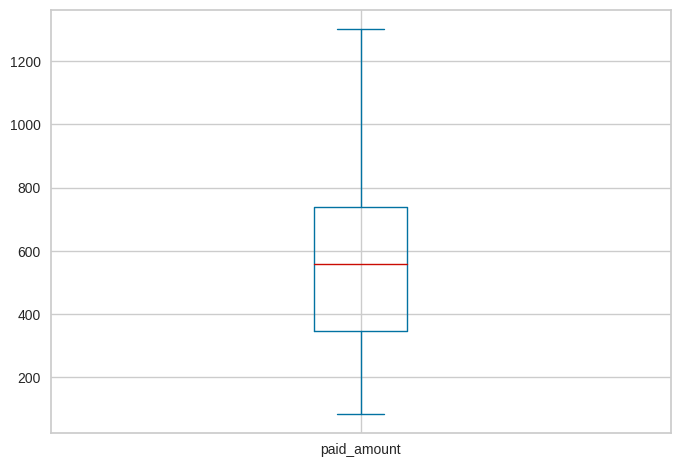

In [ ]:
# target variable plot (이상치 검증)
data_set['paid_amount'].plot.box()

In [ ]:
ohe_encoders = {}

len(data_set['port_of_discharge'].value_counts().keys())
for c in ['port_of_loading', 'port_of_discharge']:
    ohe_encoders[c] = OneHotEncoder(sparse_output=False)
    data_set = pd.concat([data_set, pd.DataFrame(ohe_encoders[c].fit_transform(data_set[[c]]), columns = [c+'_ohe_' + str(i) for i in range(len(data_set[c].value_counts().keys()))])], axis=1)
    selected_for_x += [c+'_ohe_' + str(i) for i in range(len(data_set[c].value_counts().keys()))]

In [ ]:
len(data_set['port_of_discharge'].value_counts().keys())

5

In [ ]:
data_set.head()

,port_of_loading,port_of_discharge,HSCODE,is_coc,cargo_weight,expected_time_of_departure,teu,paid_amount,kr_holiday,year,...,day,port_of_loading_ohe_0,port_of_loading_ohe_1,port_of_loading_ohe_2,port_of_loading_ohe_3,port_of_discharge_ohe_0,port_of_discharge_ohe_1,port_of_discharge_ohe_2,port_of_discharge_ohe_3,port_of_discharge_ohe_4
0,KRMAS,JPNGO,585089,1,22.502334,2022-04-13,7,671.033860,0,2022,...,13,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,KRPUN,JPNGO,200244,0,23.879217,2023-03-12,7,1061.490580,0,2023,...,12,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,KRPUS,JPTYO,159150,1,7.049077,2022-09-28,1,136.779387,0,2022,...,28,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,KRMAS,JPKNZ,784932,0,17.018100,2022-04-17,7,776.686991,0,2022,...,17,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,KRPUS,JPTRG,592176,0,18.331793,2022-03-13,7,907.256793,0,2022,...,13,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
selected_for_x

['HSCODE',
 'is_coc',
 'cargo_weight',
 'year',
 'month',
 'day',
 'teu',
 'kr_holiday',
 'port_of_loading_ohe_0',
 'port_of_loading_ohe_1',
 'port_of_loading_ohe_2',
 'port_of_loading_ohe_3',
 'port_of_discharge_ohe_0',
 'port_of_discharge_ohe_1',
 'port_of_discharge_ohe_2',
 'port_of_discharge_ohe_3',
 'port_of_discharge_ohe_4']

In [ ]:
X = data_set[selected_for_x].copy()
Y = data_set[target].copy()

In [ ]:
pca = PCA(n_components = 2, random_state=42)

In [ ]:
scaler = StandardScaler()

PCA_Data = pd.DataFrame(pca.fit_transform(scaler.fit_transform(pd.concat([X, Y], axis=1))))

In [ ]:
PCA_Data.columns = ['pca1', 'pca2']
PCA_Data

,pca1,pca2
0,0.800238,-0.098719
1,2.462229,1.807596
2,-2.815119,-1.931218
3,1.221628,-0.876358
4,1.723065,-1.223255
...,...,...
9995,0.839169,-1.864132
9996,0.276433,-1.775956
9997,1.821283,1.175204
9998,-1.886005,-0.982499


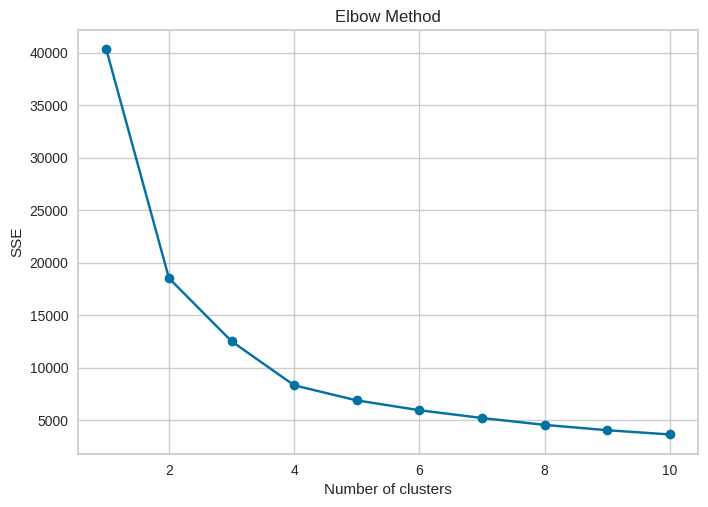

In [ ]:
# 엘보우 메서드
def elbow_method(data, max_clusters=10):
    sse = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_init=20, n_clusters=k, init='k-means++', random_state=0)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    return sse

# 클러스터 개수 결정
def determine_clusters(data, max_clusters=10):
    sse = elbow_method(data, max_clusters)
    plt.plot(range(1, max_clusters+1), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method')
    plt.show()

# 실행
determine_clusters(PCA_Data)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


<Axes: xlabel='pca1', ylabel='pca2'>

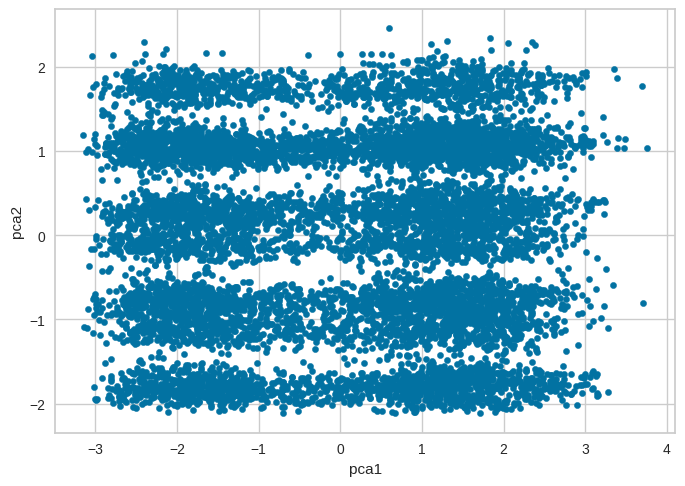

In [ ]:
PCA_Data.plot.scatter(x='pca1', y='pca2')

In [ ]:
kmeans_4 = KMeans(n_init=20, n_clusters=5, init='k-means++', random_state=42)
kmeans_4.fit(PCA_Data)
PCA_Data = pd.concat([PCA_Data ,pd.DataFrame(kmeans_4.predict(PCA_Data), columns=['KmeansC'])], axis=1)

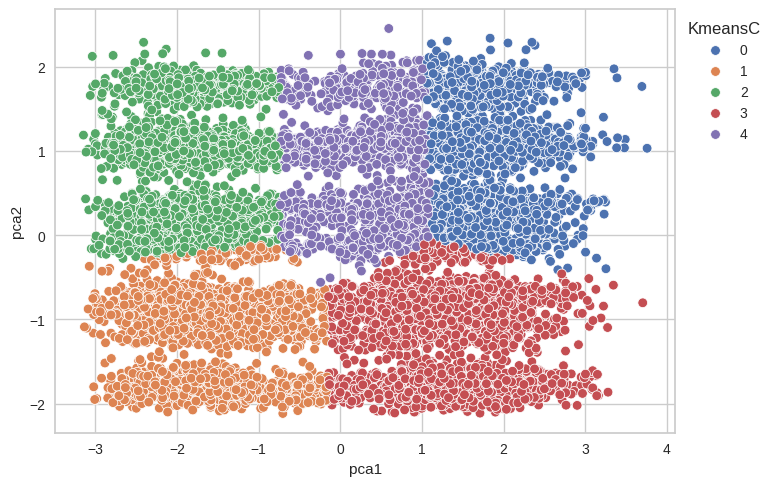

In [ ]:
ax = sns.scatterplot(x='pca1', y='pca2', hue='KmeansC', data=PCA_Data, palette="deep")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(PCA_Data[['pca1', 'pca2']].copy())
PCA_Data['gmmC'] = gmm.predict(PCA_Data[['pca1', 'pca2']].copy())

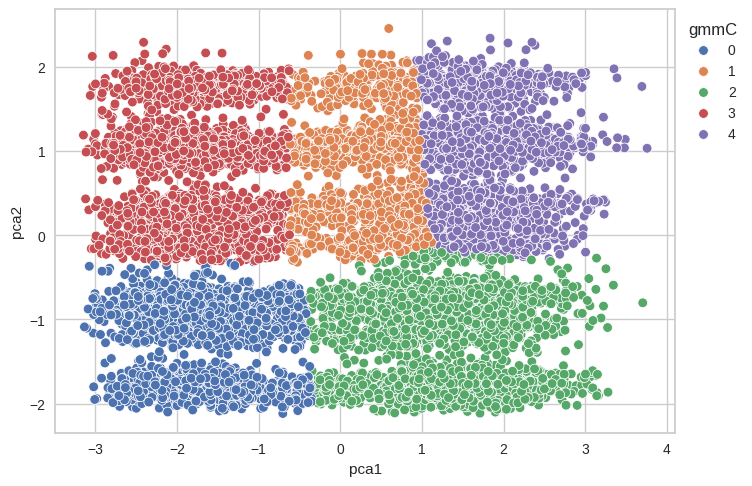

In [ ]:
ax = sns.scatterplot(x='pca1', y='pca2', hue='gmmC', data=PCA_Data, palette="deep")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
DBSCAN_model = DBSCAN(eps=0.087, min_samples=8)
DBSCAN_model.fit((PCA_Data[['pca1', 'pca2']].copy()))
# eps=0.087, min_samples=8

DBSCAN(eps=0.087, min_samples=8)

In [ ]:
PCA_Data['DBSCANC'] = DBSCAN_model.fit_predict(PCA_Data[['pca1', 'pca2']].copy())

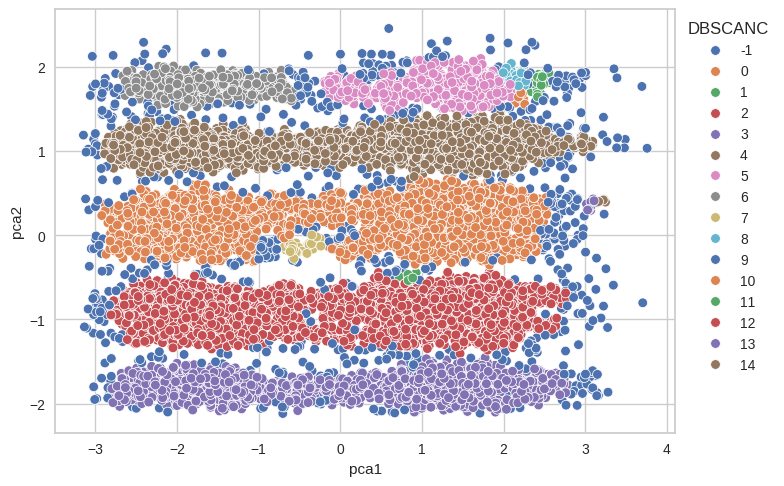

In [ ]:
ax = sns.scatterplot(x='pca1', y='pca2', hue='DBSCANC', data=PCA_Data, palette="deep")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
birchmodel = Birch(n_clusters=5)
birchmodel.fit((PCA_Data[['pca1', 'pca2']].copy()))
PCA_Data['birchC'] = birchmodel.fit_predict(PCA_Data[['pca1', 'pca2']].copy())

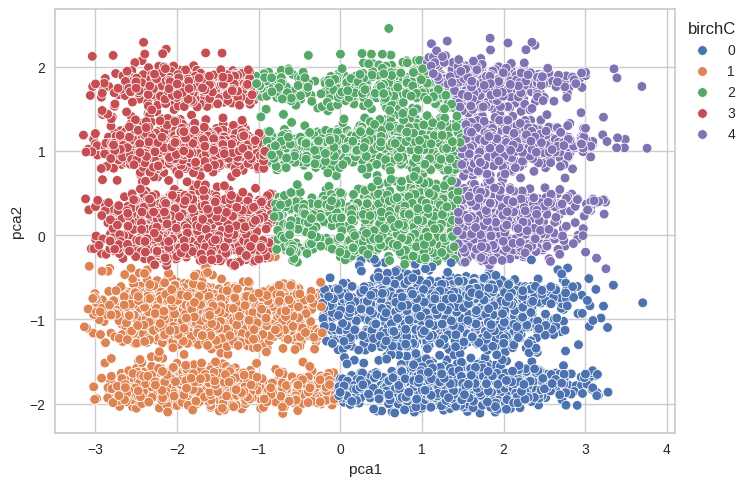

In [ ]:
ax = sns.scatterplot(x='pca1', y='pca2', hue='birchC', data=PCA_Data, palette="deep")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
PCA_Data

,pca1,pca2,KmeansC,gmmC,DBSCANC,aggC,birchC
0,0.800238,-0.098719,4,1,0,2,2
1,2.462229,1.807596,0,4,1,4,4
2,-2.815119,-1.931218,1,0,-1,1,1
3,1.221628,-0.876358,3,2,2,0,0
4,1.723065,-1.223255,3,2,2,0,0
...,...,...,...,...,...,...,...
9995,0.839169,-1.864132,3,2,3,0,0
9996,0.276433,-1.775956,3,2,3,0,0
9997,1.821283,1.175204,0,4,4,4,4
9998,-1.886005,-0.982499,1,0,2,1,1


In [ ]:
X['cluster'] = PCA_Data['birchC']

In [ ]:
total_data = pd.concat([X, Y], axis=1)

In [ ]:
total_data['cluster'].value_counts()

cluster
3    2269
2    2267
0    2234
1    1725
4    1505
Name: count, dtype: int64

In [ ]:
total_data.groupby('cluster')['paid_amount'].mean()

cluster
0    737.364969
1    334.708518
2    606.216370
3    304.229808
4    859.576722
Name: paid_amount, dtype: float64

In [ ]:
total_data.columns

Index(['HSCODE', 'is_coc', 'cargo_weight', 'year', 'month', 'day', 'teu',
       'kr_holiday', 'port_of_loading_ohe_0', 'port_of_loading_ohe_1',
       'port_of_loading_ohe_2', 'port_of_loading_ohe_3',
       'port_of_discharge_ohe_0', 'port_of_discharge_ohe_1',
       'port_of_discharge_ohe_2', 'port_of_discharge_ohe_3',
       'port_of_discharge_ohe_4', 'cluster', 'paid_amount'],
      dtype='object')

In [ ]:
total_data.groupby('cluster').mean()

,HSCODE,is_coc,cargo_weight,year,month,day,teu,kr_holiday,port_of_loading_ohe_0,port_of_loading_ohe_1,port_of_loading_ohe_2,port_of_loading_ohe_3,port_of_discharge_ohe_0,port_of_discharge_ohe_1,port_of_discharge_ohe_2,port_of_discharge_ohe_3,port_of_discharge_ohe_4,paid_amount
cluster,,,,,,,,,,,,,,,,,,
0,547285.259176,0.483438,15.163840,2022.827663,3.311549,15.406446,6.500895,0.047896,0.371083,0.000000,0.000000,0.628917,0.250671,0.123993,0.246643,0.116831,0.261862,737.364969
1,556567.713043,0.507826,14.663280,2022.502029,9.372754,16.347246,2.639420,0.041159,0.375652,0.000000,0.000000,0.624348,0.252754,0.114203,0.256812,0.118261,0.257971,334.708518
2,547565.757389,0.610940,14.750346,2022.588443,4.232907,14.913101,5.656815,0.057786,0.151742,0.430084,0.418174,0.000000,0.179532,0.232907,0.170269,0.246581,0.170710,606.216370
3,542883.289996,0.549141,14.659359,2022.469810,9.744381,16.095196,2.372851,0.052446,0.173645,0.420009,0.406346,0.000000,0.161305,0.243720,0.171441,0.250331,0.173204,304.229808
4,554658.916944,0.289037,15.619453,2023.255814,2.930897,15.512957,7.087708,0.052492,0.158804,0.405980,0.435216,0.000000,0.161462,0.263787,0.155482,0.257807,0.161462,859.576722


from matplotlib import pyplot as plt
_df_0['cluster'].plot(kind='hist', bins=20, title='cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['HSCODE'].plot(kind='hist', bins=20, title='HSCODE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['is_coc'].plot(kind='hist', bins=20, title='is_coc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['cargo_weight'].plot(kind='hist', bins=20, title='cargo_weight')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='cluster', y='HSCODE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='HSCODE', y='is_coc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='is_coc', y='cargo_weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='cargo_weight', y='year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['cluster']
  ys = series['HSCODE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('cluster')
_ = plt.ylabel('HSCODE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['cluster']
  ys = series['is_coc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('cluster')
_ = plt.ylabel('is_coc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['cluster']
  ys = series['cargo_weight']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('cluster')
_ = plt.ylabel('cargo_weight')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['cluster']
  ys = series['month']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('cluster')
_ = plt.ylabel('month')

from matplotlib import pyplot as plt
_df_12['cluster'].plot(kind='line', figsize=(8, 4), title='cluster')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['HSCODE'].plot(kind='line', figsize=(8, 4), title='HSCODE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['is_coc'].plot(kind='line', figsize=(8, 4), title='is_coc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['cargo_weight'].plot(kind='line', figsize=(8, 4), title='cargo_weight')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
total_data.columns[1]

'is_coc'

In [ ]:
total_data.columns

Index(['HSCODE', 'is_coc', 'cargo_weight', 'year', 'month', 'day', 'teu',
       'kr_holiday', 'port_of_loading_ohe_0', 'port_of_loading_ohe_1',
       'port_of_loading_ohe_2', 'port_of_loading_ohe_3',
       'port_of_discharge_ohe_0', 'port_of_discharge_ohe_1',
       'port_of_discharge_ohe_2', 'port_of_discharge_ohe_3',
       'port_of_discharge_ohe_4', 'cluster', 'paid_amount'],
      dtype='object')

In [ ]:
total_data.groupby('cluster').sum()

,HSCODE,is_coc,cargo_weight,year,month,day,teu,kr_holiday,port_of_loading_ohe_0,port_of_loading_ohe_1,port_of_loading_ohe_2,port_of_loading_ohe_3,port_of_discharge_ohe_0,port_of_discharge_ohe_1,port_of_discharge_ohe_2,port_of_discharge_ohe_3,port_of_discharge_ohe_4,paid_amount
cluster,,,,,,,,,,,,,,,,,,
0,1222635269,1080,33876.017483,4518997,7398,34418,14523,107,829.0,0.0,0.0,1405.0,560.0,277.0,551.0,261.0,585.0,1.647273e+06
1,960079305,876,25294.158752,3488816,16168,28199,4553,71,648.0,0.0,0.0,1077.0,436.0,197.0,443.0,204.0,445.0,5.773722e+05
2,1241331572,1385,33439.034253,4585208,9596,33808,12824,131,344.0,975.0,948.0,0.0,407.0,528.0,386.0,559.0,387.0,1.374293e+06
3,1231802185,1246,33262.085930,4588984,22110,36520,5384,119,394.0,953.0,922.0,0.0,366.0,553.0,389.0,568.0,393.0,6.902974e+05
4,834761670,435,23507.276044,3045000,4411,23347,10667,79,239.0,611.0,655.0,0.0,243.0,397.0,234.0,388.0,243.0,1.293663e+06


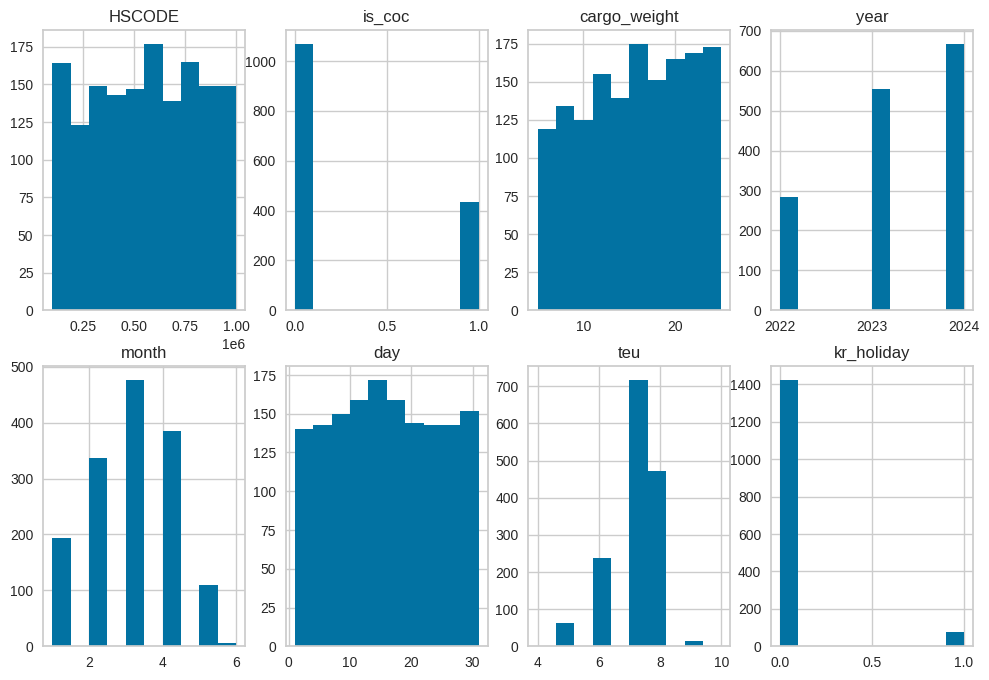

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.hist(total_data[total_data['cluster'] == 4][total_data.columns[i]], bins=10)
    plt.title(total_data.columns[i])

plt.show()

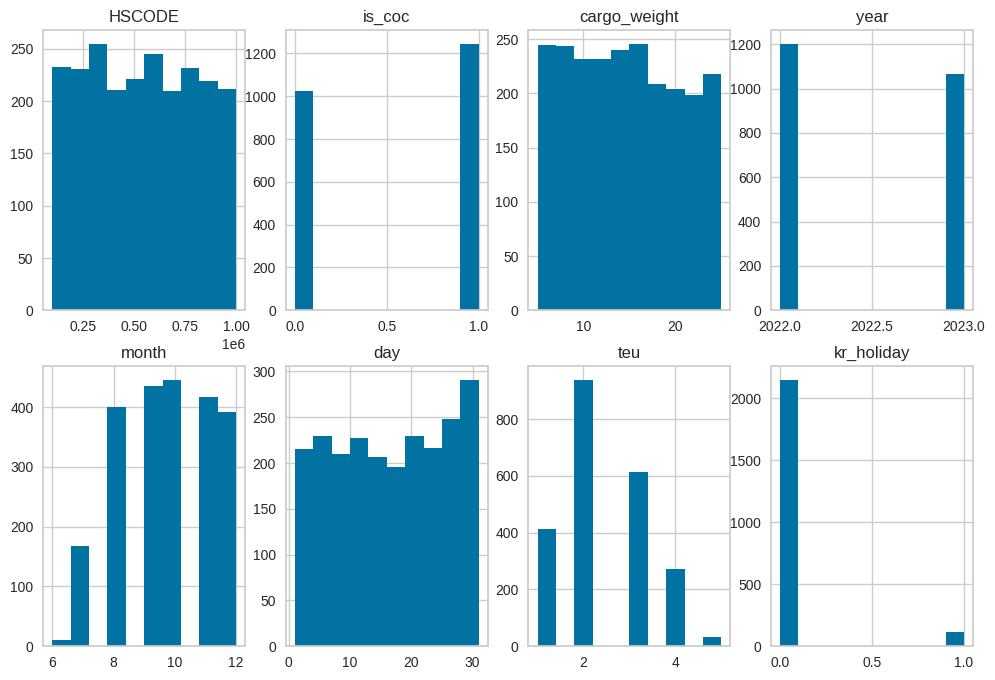

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.hist(total_data[total_data['cluster'] == 3][total_data.columns[i]], bins=10)
    plt.title(total_data.columns[i])

plt.show()

In [ ]:
X = total_data[selected_for_x].copy()
Y = total_data[target].copy()

In [ ]:
train_data = total_data[~((total_data['year']==2024) & (total_data['month']==4))]
test_data = total_data[(total_data['year']==2024) & (total_data['month']==4)]

In [ ]:
train_data_x, train_data_y = train_data[selected_for_x].copy(), train_data[target].copy()
test_data_x, test_data_y = test_data[selected_for_x].copy(), test_data[target].copy()

In [ ]:
train_data_x

,HSCODE,is_coc,cargo_weight,year,month,day,teu,kr_holiday,port_of_loading_ohe_0,port_of_loading_ohe_1,port_of_loading_ohe_2,port_of_loading_ohe_3,port_of_discharge_ohe_0,port_of_discharge_ohe_1,port_of_discharge_ohe_2,port_of_discharge_ohe_3,port_of_discharge_ohe_4
0,585089,1,22.502334,2022,4,13,7,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,200244,0,23.879217,2023,3,12,7,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,159150,1,7.049077,2022,9,28,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,784932,0,17.018100,2022,4,17,7,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,592176,0,18.331793,2022,3,13,7,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,933355,1,14.487170,2023,1,31,6,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9996,785924,1,11.468679,2023,6,11,6,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9997,480746,1,7.352066,2023,2,19,8,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
9998,866148,1,11.040653,2023,9,5,2,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train_data_y

,paid_amount
0,671.033860
1,1061.490580
2,136.779387
3,776.686991
4,907.256793
...,...
9995,478.157454
9996,535.969472
9997,763.504033
9998,241.307729


In [ ]:
iris = KFold(n_splits=5, shuffle=True, random_state=42)
i = 0
RF_models = {}
CB_models = {}
LGBM_models = {}
GBM_models = {}
mlp_models = {}

RF_score = []
CB_score = []
LGBM_score = []
GBM_score = []
mlp_score = []

In [ ]:
for train_idx, test_idx in iris.split(train_data_x, train_data_y):
    RF_models[i] = RandomForestRegressor(random_state=42)
    CB_models[i] = CatBoostRegressor(random_state=42)
    LGBM_models[i] = LGBMRegressor(random_state=42)
    GBM_models[i] = GradientBoostingRegressor(random_state=42)
    mlp_models[i] = MLPRegressor(random_state=42)

    RF_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])
    CB_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])
    LGBM_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])
    GBM_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])
    mlp_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])

    rfpred = RF_models[i].predict(train_data_x.iloc[test_idx])
    cbpred = CB_models[i].predict(train_data_x.iloc[test_idx])
    lgbmpred = LGBM_models[i].predict(train_data_x.iloc[test_idx])
    gbmpred = GBM_models[i].predict(train_data_x.iloc[test_idx])
    mlp_pred = mlp_models[i].predict(train_data_x.iloc[test_idx])

    i += 1

    RF_score.append(mean_squared_error(train_data_y.iloc[test_idx], rfpred, squared=False))
    CB_score.append(mean_squared_error(train_data_y.iloc[test_idx], cbpred, squared=False))
    LGBM_score.append(mean_squared_error(train_data_y.iloc[test_idx], lgbmpred, squared=False))
    GBM_score.append(mean_squared_error(train_data_y.iloc[test_idx], gbmpred, squared=False))
    mlp_score.append(mean_squared_error(train_data_y.iloc[test_idx], mlp_pred, squared=False))



<ipython-input-582-29d9387ebde3>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])


Learning rate set to 0.056623
0:	learn: 234.9773226	total: 2.49ms	remaining: 2.48s
1:	learn: 223.3527887	total: 4.72ms	remaining: 2.36s
2:	learn: 212.5407239	total: 6.93ms	remaining: 2.31s
3:	learn: 202.5370889	total: 9.17ms	remaining: 2.28s
4:	learn: 193.0752660	total: 11.4ms	remaining: 2.26s
5:	learn: 184.2271683	total: 13.5ms	remaining: 2.24s
6:	learn: 175.7595888	total: 16ms	remaining: 2.27s
7:	learn: 167.9190054	total: 18.4ms	remaining: 2.28s
8:	learn: 160.2689886	total: 20.8ms	remaining: 2.29s
9:	learn: 153.3248216	total: 23.3ms	remaining: 2.31s
10:	learn: 147.0789597	total: 25.8ms	remaining: 2.32s
11:	learn: 141.0072482	total: 29.4ms	remaining: 2.42s
12:	learn: 135.2211471	total: 31.8ms	remaining: 2.41s
13:	learn: 129.8312470	total: 34.6ms	remaining: 2.44s
14:	learn: 124.7489601	total: 36.8ms	remaining: 2.42s
15:	learn: 119.9545439	total: 39.5ms	remaining: 2.43s
16:	learn: 115.4771889	total: 42ms	remaining: 2.43s
17:	learn: 111.4552811	total: 44.1ms	remaining: 2.41s
18:	learn: 1

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-582-29d9387ebde3>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])


Learning rate set to 0.056623
0:	learn: 234.2113736	total: 2.39ms	remaining: 2.39s
1:	learn: 222.6306758	total: 4.68ms	remaining: 2.33s
2:	learn: 211.8642641	total: 6.86ms	remaining: 2.28s
3:	learn: 201.7804076	total: 9ms	remaining: 2.24s
4:	learn: 192.5025190	total: 11.7ms	remaining: 2.32s
5:	learn: 183.5210740	total: 14.6ms	remaining: 2.42s
6:	learn: 175.2358604	total: 16.9ms	remaining: 2.4s
7:	learn: 167.4020560	total: 19.4ms	remaining: 2.41s
8:	learn: 159.7586562	total: 21.8ms	remaining: 2.4s
9:	learn: 152.9528580	total: 24.2ms	remaining: 2.4s
10:	learn: 146.3625788	total: 26.5ms	remaining: 2.38s
11:	learn: 140.2806102	total: 29.1ms	remaining: 2.4s
12:	learn: 134.5687692	total: 31.6ms	remaining: 2.4s
13:	learn: 129.2580175	total: 34ms	remaining: 2.39s
14:	learn: 124.2380789	total: 36.2ms	remaining: 2.38s
15:	learn: 119.2082007	total: 38.7ms	remaining: 2.38s
16:	learn: 114.8130421	total: 40.9ms	remaining: 2.36s
17:	learn: 110.8156420	total: 43.1ms	remaining: 2.35s
18:	learn: 106.867

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-582-29d9387ebde3>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])


Learning rate set to 0.056623
0:	learn: 235.2601511	total: 2.48ms	remaining: 2.47s
1:	learn: 223.6359103	total: 4.72ms	remaining: 2.35s
2:	learn: 212.8306195	total: 6.91ms	remaining: 2.3s
3:	learn: 202.6801116	total: 9.11ms	remaining: 2.27s
4:	learn: 193.2150636	total: 11.4ms	remaining: 2.26s
5:	learn: 184.1317165	total: 13.8ms	remaining: 2.29s
6:	learn: 175.6913069	total: 16.2ms	remaining: 2.3s
7:	learn: 167.8019094	total: 18.4ms	remaining: 2.28s
8:	learn: 160.3669930	total: 20.7ms	remaining: 2.27s
9:	learn: 153.3456746	total: 23ms	remaining: 2.27s
10:	learn: 146.7260510	total: 25.4ms	remaining: 2.28s
11:	learn: 140.5097484	total: 28.1ms	remaining: 2.31s
12:	learn: 134.7507429	total: 30.6ms	remaining: 2.32s
13:	learn: 129.4509031	total: 32.8ms	remaining: 2.31s
14:	learn: 124.4370385	total: 35.1ms	remaining: 2.31s
15:	learn: 119.4717090	total: 37.5ms	remaining: 2.31s
16:	learn: 114.7900434	total: 40ms	remaining: 2.31s
17:	learn: 110.8248636	total: 42.2ms	remaining: 2.3s
18:	learn: 106.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-582-29d9387ebde3>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])


Learning rate set to 0.056623
0:	learn: 234.0865823	total: 2.42ms	remaining: 2.42s
1:	learn: 222.5021500	total: 4.67ms	remaining: 2.33s
2:	learn: 211.7263629	total: 6.88ms	remaining: 2.29s
3:	learn: 201.7655252	total: 9.27ms	remaining: 2.31s
4:	learn: 192.4186779	total: 11.8ms	remaining: 2.34s
5:	learn: 183.4073771	total: 14.3ms	remaining: 2.38s
6:	learn: 175.1326686	total: 16.8ms	remaining: 2.38s
7:	learn: 167.2398247	total: 19ms	remaining: 2.35s
8:	learn: 159.6882345	total: 21.6ms	remaining: 2.38s
9:	learn: 152.5779975	total: 24ms	remaining: 2.37s
10:	learn: 146.3281879	total: 26.1ms	remaining: 2.35s
11:	learn: 140.2662285	total: 28.7ms	remaining: 2.36s
12:	learn: 134.4158211	total: 30.8ms	remaining: 2.34s
13:	learn: 129.0933536	total: 33.4ms	remaining: 2.35s
14:	learn: 124.0754096	total: 35.9ms	remaining: 2.35s
15:	learn: 119.2372676	total: 38ms	remaining: 2.34s
16:	learn: 114.8092660	total: 40.4ms	remaining: 2.34s
17:	learn: 110.8151492	total: 42.9ms	remaining: 2.34s
18:	learn: 106

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-582-29d9387ebde3>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_models[i].fit(train_data_x.iloc[train_idx], train_data_y.iloc[train_idx])


Learning rate set to 0.056623
0:	learn: 232.7547402	total: 2.34ms	remaining: 2.34s
1:	learn: 221.2442772	total: 4.68ms	remaining: 2.34s
2:	learn: 210.5404572	total: 7.06ms	remaining: 2.35s
3:	learn: 200.6385989	total: 9.19ms	remaining: 2.29s
4:	learn: 191.2673655	total: 11.9ms	remaining: 2.37s
5:	learn: 182.5431169	total: 14.2ms	remaining: 2.35s
6:	learn: 174.1101675	total: 16.4ms	remaining: 2.33s
7:	learn: 166.3336503	total: 19.3ms	remaining: 2.4s
8:	learn: 159.0777273	total: 21.5ms	remaining: 2.37s
9:	learn: 152.1806288	total: 24.1ms	remaining: 2.39s
10:	learn: 145.6906085	total: 26.5ms	remaining: 2.38s
11:	learn: 139.5473063	total: 28.6ms	remaining: 2.36s
12:	learn: 133.8325607	total: 30.9ms	remaining: 2.34s
13:	learn: 128.5494453	total: 33.3ms	remaining: 2.35s
14:	learn: 123.5475244	total: 35.6ms	remaining: 2.34s
15:	learn: 118.5494161	total: 37.9ms	remaining: 2.33s
16:	learn: 114.1230086	total: 40.3ms	remaining: 2.33s
17:	learn: 110.1588613	total: 42.5ms	remaining: 2.32s
18:	learn

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print('----Validation RMSE----')
print(f"{np.mean(RF_score):.2f}", 'RF')
print(f"{np.mean(CB_score):.2f}", 'CB')
print(f"{np.mean(LGBM_score):.2f}", 'LGBM')
print(f"{np.mean(GBM_score):.2f}", 'GBM')
print(f"{np.mean(mlp_score):.2f}", 'MLP')

----Validation RMSE----
63.78 RF
62.67 CB
62.05 LGBM
60.72 GBM
244.05 MLP


In [ ]:
RF_test = []
CB_test = []
LGBM_test = []
GBM_test = []
mlp_test = []

for i in range(5):
    rf_pred = RF_models[i].predict(test_data_x)
    cb_pred = CB_models[i].predict(test_data_x)
    lgbm_pred = LGBM_models[i].predict(test_data_x)
    gbm_pred = GBM_models[i].predict(test_data_x)
    mlp_pred = mlp_models[i].predict(test_data_x)

    RF_test.append(mean_squared_error(rf_pred, test_data_y, squared=False))
    CB_test.append(mean_squared_error(cb_pred, test_data_y, squared=False))
    LGBM_test.append(mean_squared_error(lgbm_pred, test_data_y, squared=False))
    GBM_test.append(mean_squared_error(gbm_pred, test_data_y, squared=False))
    mlp_test.append(mean_squared_error(mlp_pred, test_data_y, squared=False))

In [ ]:
print('-----test RMSE-----')
print(np.mean(RF_test), 'RF')
print(np.mean(CB_test), 'CB')
print(np.mean(LGBM_test), 'LGBM')
print(np.mean(GBM_test), 'GBM')
print(np.mean(mlp_test), 'MLP')

-----test RMSE-----
95.68390764331083 RF
94.43056885472578 CB
94.74084059621816 LGBM
92.38236226260094 GBM
328.7503055731266 MLP


In [ ]:
# validation 에서 가장 좋은 성능 GBM이 test에서도 가장 좋은 걸 확인 (실제 데이터 에서는 test가 없음)

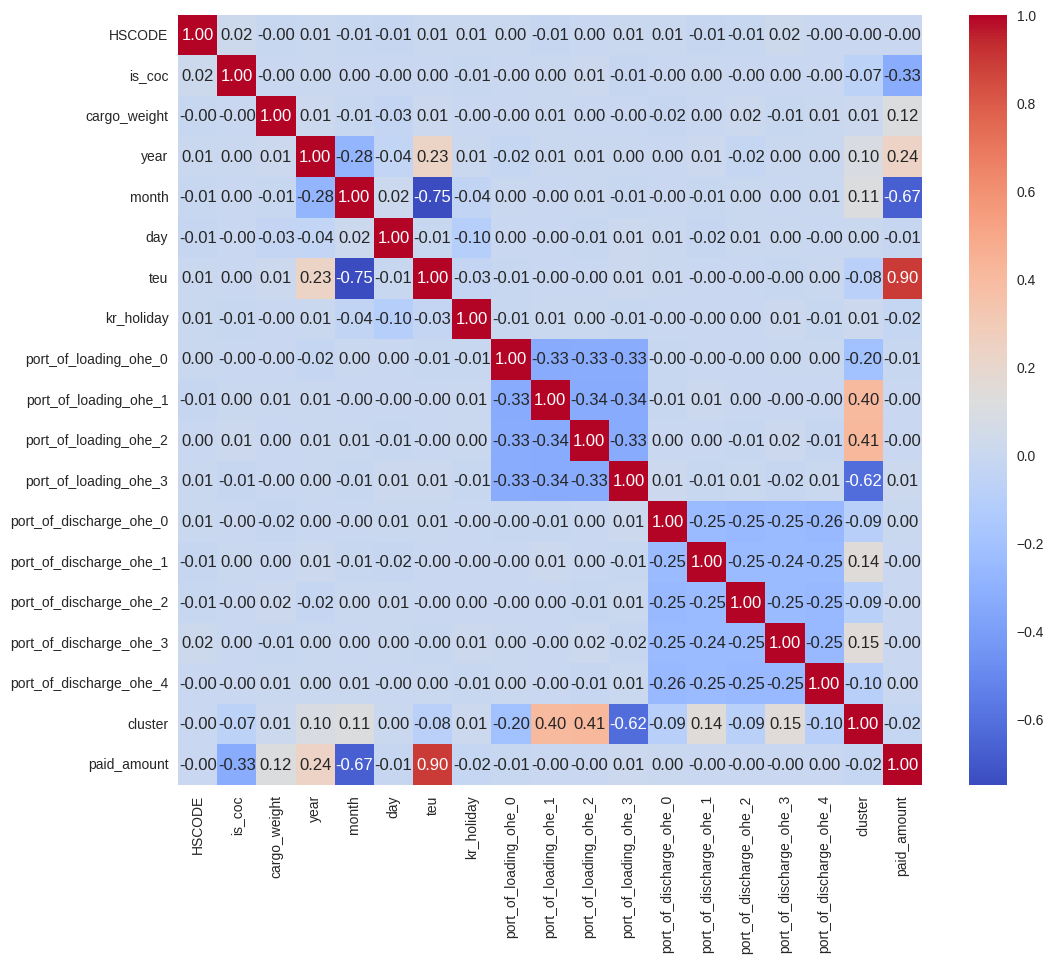

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(total_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [ ]:
for model in GBM_models.values():
    ser = pd.Series(model.feature_importances_, index=train_data_x.columns)
    # 내림차순 정렬을 이용한다
    top7 = ser.sort_values(ascending=False)[:7]
    print(top7)
    print('-------------------------------')

teu             0.847521
is_coc          0.135849
cargo_weight    0.013598
year            0.001594
HSCODE          0.000797
day             0.000230
month           0.000217
dtype: float64
-------------------------------
teu                        0.848038
is_coc                     0.134328
cargo_weight               0.014304
year                       0.001773
HSCODE                     0.000903
day                        0.000248
port_of_discharge_ohe_3    0.000180
dtype: float64
-------------------------------
teu             0.852527
is_coc          0.130516
cargo_weight    0.013761
year            0.001842
HSCODE          0.000795
month           0.000220
day             0.000197
dtype: float64
-------------------------------
teu             0.850413
is_coc          0.132464
cargo_weight    0.013904
year            0.001791
HSCODE          0.000679
month           0.000344
day             0.000209
dtype: float64
-------------------------------
teu             0.854769
is_coc    